In [ ]:
!pip install einops
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00
time: 336 µs (started: 2023-12-05 00:02:06 +00:00)


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

time: 9.03 s (started: 2023-12-05 00:02:06 +00:00)


In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

time: 1.14 ms (started: 2023-12-04 15:15:53 +00:00)


In [ ]:
class ViT_Columns(nn.Module):
    def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = image_size

        # Each "patch" is a column of pixels
        patch_height = image_height  # height of the image
        patch_width = 1              # width is 1 pixel

        # The number of patches is the width of the image
        num_patches = image_width
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c h (w) -> b w (h c)', h = patch_height),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

time: 1.76 ms (started: 2023-12-04 16:29:17 +00:00)


In [ ]:
self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h w) -> b (h w) c', h=patch_height, w=patch_width),
            nn.Linear(patch_dim, dim),
        )

Rearrange('b c h (w) -> b w (h c)', h = patch_height),

NameError: ignored

time: 15.4 ms (started: 2023-12-05 00:04:10 +00:00)


In [ ]:
class ViT_Rows(nn.Module):
    def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = image_size

        # Each "patch" is a row of pixels
        patch_height = 1
        patch_width = image_width

        # The number of patches is the height of the image
        num_patches = image_height
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h) w -> b h (w c)', w = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

time: 2.33 ms (started: 2023-12-05 00:06:34 +00:00)


In [ ]:
image_height = 32
image_width = 32
device = 'cuda'

time: 499 µs (started: 2023-12-05 00:06:37 +00:00)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize to match ViT input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43792244.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
time: 7.47 s (started: 2023-12-05 00:02:50 +00:00)


In [ ]:
learning_rate = 0.0001
epochs = 12

model = ViT(
    image_size=(32, 32),
    patch_size=(4, 4),
    num_classes=10,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    channels=3,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 171 ms (started: 2023-12-04 16:27:59 +00:00)


In [ ]:
learning_rate = 0.0001
epochs = 12

model = ViT_Columns(
    image_size=(32, 32),
    num_classes=10,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    channels=3,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 102 ms (started: 2023-12-04 16:34:04 +00:00)


In [ ]:
learning_rate = 0.0001
epochs = 12

model = ViT_Rows(
    image_size=(32, 32),
    num_classes=10,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    channels=3,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 104 ms (started: 2023-12-05 00:06:40 +00:00)


In [ ]:
for epoch in range(4):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

KeyboardInterrupt: ignored

time: 1.63 s (started: 2023-12-05 00:26:44 +00:00)


In [ ]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 60.84%
time: 5.5 s (started: 2023-12-05 00:26:48 +00:00)


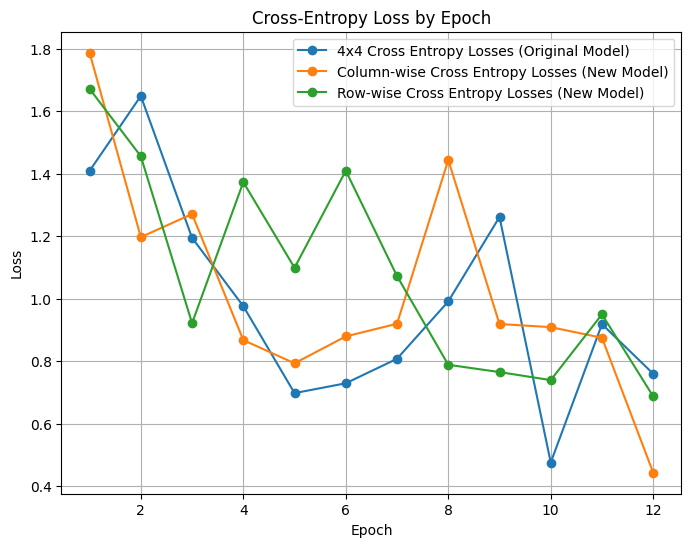

time: 294 ms (started: 2023-12-05 00:21:42 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Define the list of epochs and corresponding losses for the previous dataset
epochs_prev = list(range(1, 13))
losses_prev = [
    1.4095487594604492,
    1.6492977142333984,
    1.1951779127120972,
    0.9763784408569336,
    0.6980234980583191,
    0.7295193076133728,
    0.8079758882522583,
    0.9914300441741943,
    1.2619496583938599,
    0.47578567266464233,
    0.9187636375427246,
    0.7599000930786133,
]

# Define the list of epochs and corresponding losses for the new dataset
epochs_columns = list(range(1, 13))
losses_columns = [
    1.7877891063690186,
    1.197339653968811,
    1.2713712453842163,
    0.8677396178245544,
    0.7934479117393494,
    0.8795289993286133,
    0.9200887680053711,
    1.4444973468780518,
    0.9192518591880798,
    0.909235417842865,
    0.8751729130744934,
    0.44314706325531006,
]

epochs_rows = list(range(1,13))
losses_rows = [
    1.6721045970916748,
    1.456254005432129,
    0.9217549562454224,
    1.3734996318817139,
    1.099267840385437,
    1.4099277257919312,
    1.0726791620254517,
    0.7887203693389893,
    0.7653316259384155,
    0.7396463751792908,
    0.9502152800559998,
    0.6873401403427124
]


# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_prev, losses_prev, marker='o', linestyle='-', label='4x4 Cross Entropy Losses (Original Model)')
plt.plot(epochs_columns, losses_columns, marker='o', linestyle='-', label='Column-wise Cross Entropy Losses (New Model)')
plt.plot(epochs_rows, losses_rows, marker='o', linestyle='-', label='Row-wise Cross Entropy Losses (New Model)')
plt.title('Cross-Entropy Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Original
# 61.27% accuracy
# Takes 18m 2s to train

# New
# 61.3% accuracy
# Takes 9m 29s to train

# New
# 61.3% accuracy
# takes 9m 21s to train

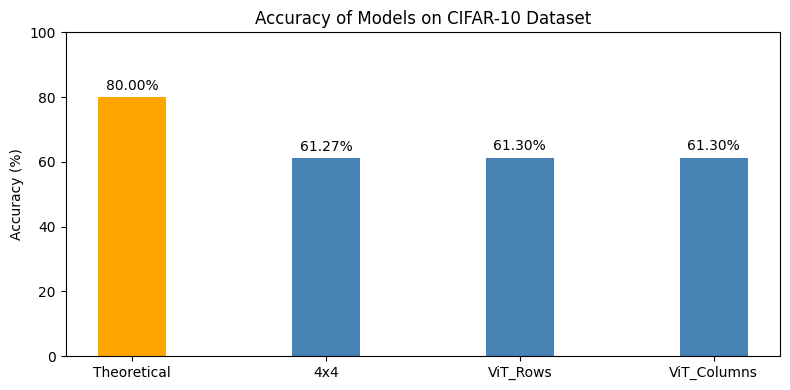

In [22]:
import matplotlib.pyplot as plt

# Data
labels = ['Theoretical', '4x4', 'ViT_Rows', 'ViT_Columns']
values = [80.0, 61.27, 61.3, 61.3]

# Create a bar plot with custom width
bar_width = 0.35  # Adjust the width as needed
plt.figure(figsize=(8, 4))  # Adjust figure size as needed

# Create the bar plot
bars = plt.bar(labels, values, color=['orange', 'steelblue', 'steelblue', 'steelblue'], width=bar_width)

# Add title and labels
plt.title('Accuracy of Models on CIFAR-10 Dataset')
plt.ylabel('Accuracy (%)')  # Adjust the Y-axis label

# Set Y-axis limits to go up to 100%
plt.ylim(0, 100)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',  # Format the label as a percentage with two decimal places
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Offset label slightly above the bar
                 textcoords='offset points',
                 ha='center', va='bottom')

# Display the plot
plt.tight_layout()  # Optional: Adjust layout for better spacing
plt.show()


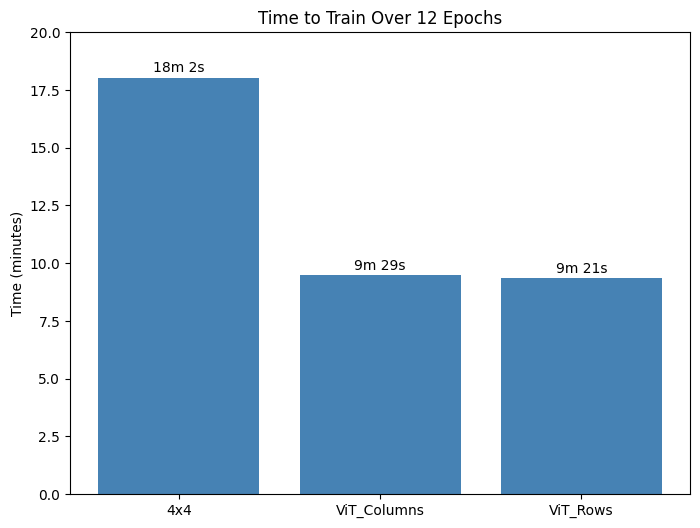

In [27]:
import matplotlib.pyplot as plt
import re

# Time values in minutes and seconds
time_values = ['18m 2s', '9m 29s', '9m 21s']

# Extract and convert time values to minutes
time_in_minutes = [18.033, 9.4833,  9.3500]
bar_width = 0.2  # Adjust the width as needed

# Labels for the bars
labels = ['4x4', 'ViT_Columns', 'ViT_Rows']

# Create a bar plot
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size

bars = plt.bar(labels, time_in_minutes, color = ['steelblue', 'steelblue', 'steelblue'])

# Add title and labels
plt.title('Time to Train Over 12 Epochs')
plt.ylabel('Time (minutes)')  # Adjust the Y-axis label
plt.ylim(0, 20)

# Add labels above the bars
for bar, label in zip(bars, time_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, label,
             ha='center', va='bottom')

# Display the plot
plt.show()
